# CP255: Using Pandana to Measure Multi-Modal Accessibility with Automobile, Pedestrian, and Transit Networks

This session introduces the Pandana Library (Pandas Network Analysis), developed as part of the Urban Data Science Toolkit.

The session covers: 

* acquisition of OpenStreetMap (OSM) street network data 
* nearest neighbor 
* cumulative accessibility 
* queries on auto, pedestrian, and transit networks.

In [1]:
import pandana as pdna
# from pandana.loaders import osm
import pandas as pd
from ipywidgets import FloatSlider, interact
from IPython.core.display import display
from urbansim.utils import misc
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [2]:
data_path = 'data/'

# Transit+Pedestrian network

The transit+pedestrian network used here was created using UrbanAccess. UrbanAccess is a Python General Transit Feed Specification (GTFS) data acquisition, processing, and Pandana network creation tool designed to be used in tandem with Pandana for accessibility queries. UrbanAccess includes tools: 1) to connect and search GTFS data APIs; 2) validate GTFS data; 3) create individual agency or metropolitan scale transit networks; 4) compute headways; 5) penalize network impedance by transit mode.

The UrbanAccess library will soon be on UDST: https://github.com/UDST/

For more detailed information on UrbanAccess see:

Samuel D. Blanchard and Paul Waddell. 2017. ["UrbanAccess: A Generalized Methodology for Measuring Regional Accessibility with an Integrated Pedestrian and Transit Network"](https://trrjournalonline.trb.org/doi/pdf/10.3141/2653-05) Transportation Research Record: Journal of the Transportation Research Board.

In [3]:
%%time
blocks = pd.read_csv(data_path+'blocks_subset.csv', index_col='block_id')
jobs = pd.read_csv(data_path+'jobs_subset.csv', index_col='job_id')
households = pd.read_csv(data_path+'households_subset.csv', index_col='block_id')

hdffile = 'transit_ped_network.h5'
transit_nodes = pd.HDFStore(data_path+hdffile).nodes
transit_edges = pd.HDFStore(data_path+hdffile).edges
transit_edges.drop('id', axis=1, inplace=True)

print('Loaded',str(len(blocks)),'blocks',str(len(jobs)),'jobs',str(len(households)),'households')
print('Loaded',str(len(transit_nodes)),'nodes',str(len(transit_edges)),'edges')

Loaded 32418 blocks 922291 jobs 766484 households
Loaded 114536 nodes 217767 edges
CPU times: user 1.33 s, sys: 163 ms, total: 1.49 s
Wall time: 1.49 s


The transit network represents the AM Peak scheduled network of AC Transit from 7 am to 10 am with edges weighted by travel time. Pedestrian to transit connector edges have been weighted by the average route stop headways to represent expected passenger wait time. This network has been integrated with the pedestrian network which uses a standard walking speed of 3 MPH to calculate the pedestrian travel time.

In [4]:
%%time
transit_net = pdna.Network(transit_nodes["x"], 
                           transit_nodes["y"], 
                           transit_edges["from"], 
                           transit_edges["to"],
                           transit_edges[["weight"]],twoway=False)

CPU times: user 19.5 s, sys: 102 ms, total: 19.6 s
Wall time: 19.6 s


In [5]:
%%time
%%capture
blocks['node_id'] = transit_net.get_node_ids(blocks['x'], blocks['y'])
blocks['jobs'] = jobs.groupby(jobs.block_id).size()
transit_net.set(blocks.node_id, variable = blocks.jobs, name='transit_jobs')

CPU times: user 91.5 ms, sys: 21.8 ms, total: 113 ms
Wall time: 112 ms


Run an aggregation query to calculate the total number of jobs accessible within a 20 minute travel time along the transit+pedestrian network.

In [6]:
%%time
transit_jobs_20 = transit_net.aggregate(20, type='sum', decay='linear', name = 'transit_jobs')

CPU times: user 2min 4s, sys: 620 ms, total: 2min 5s
Wall time: 2min 4s


In [7]:
results_transit = pd.DataFrame({'transit_jobs_20':misc.reindex(transit_jobs_20, blocks.node_id)})
results_transit.tail()

,transit_jobs_20
block_id,
60855112001002,3453.855635
60855046021011,0.000000
60855044222007,5376.646034
60855044221003,2334.763586
60855044203011,16.702500


## View results on a map

### Alameda County

### 20 min

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a145779b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10ff3df98>)

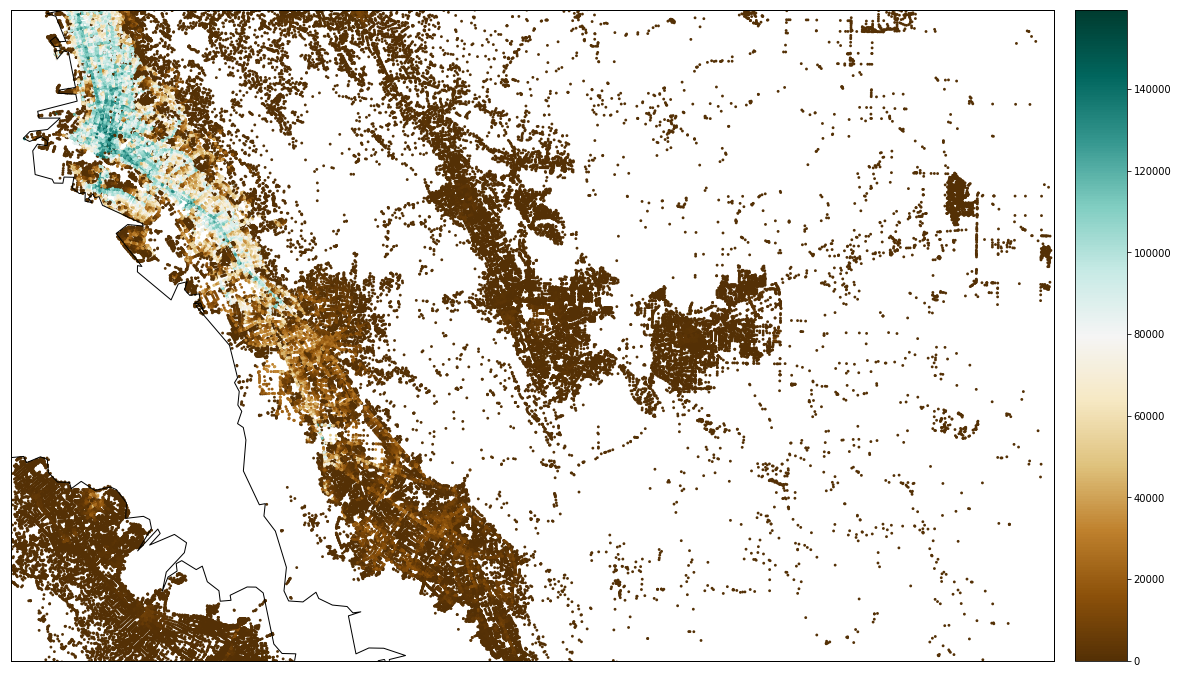

In [14]:
bbox = (37.454539,-122.342665,37.905668,-121.469214) # alameda county
transit_net.plot(transit_jobs_20, 
         bbox=bbox,
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'3310','resolution':'h'},
         plot_kwargs={'cmap':'BrBG','s':8,'edgecolor':'none'})

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a14e7b160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x112303a58>)

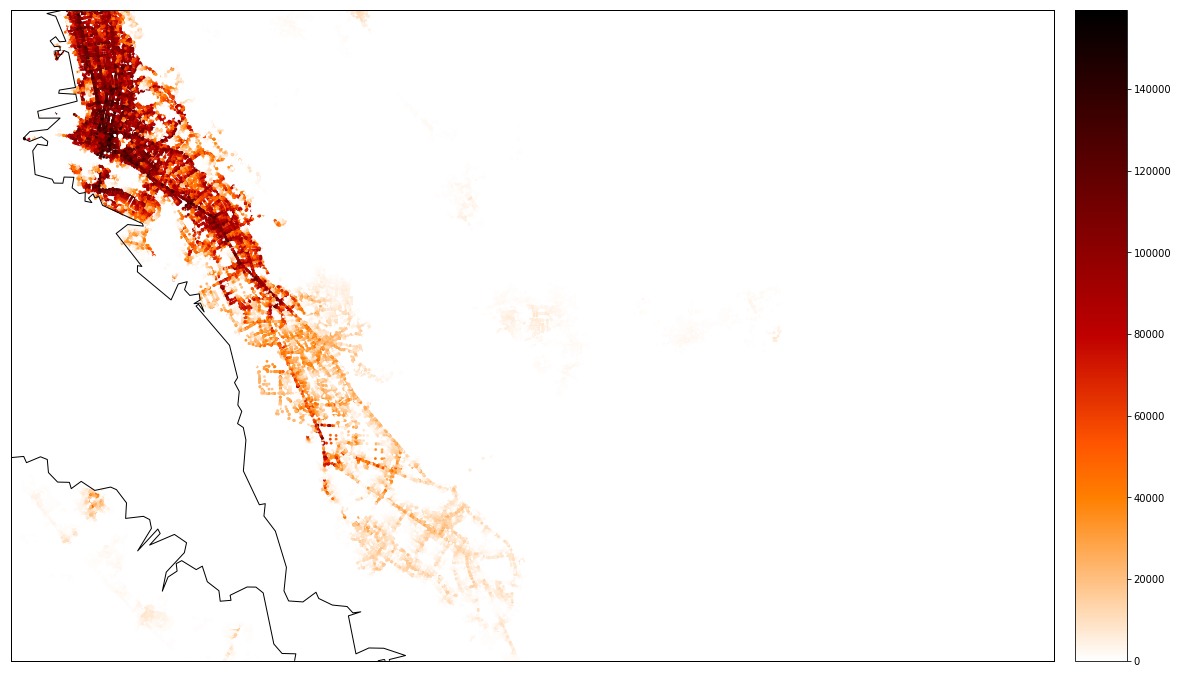

In [15]:
bbox = (37.454539,-122.342665,37.905668,-121.469214) # alameda county
transit_net.plot(transit_jobs_20, 
         bbox=bbox,
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'3310','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

### Oakland

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a14f147b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10fee23c8>)

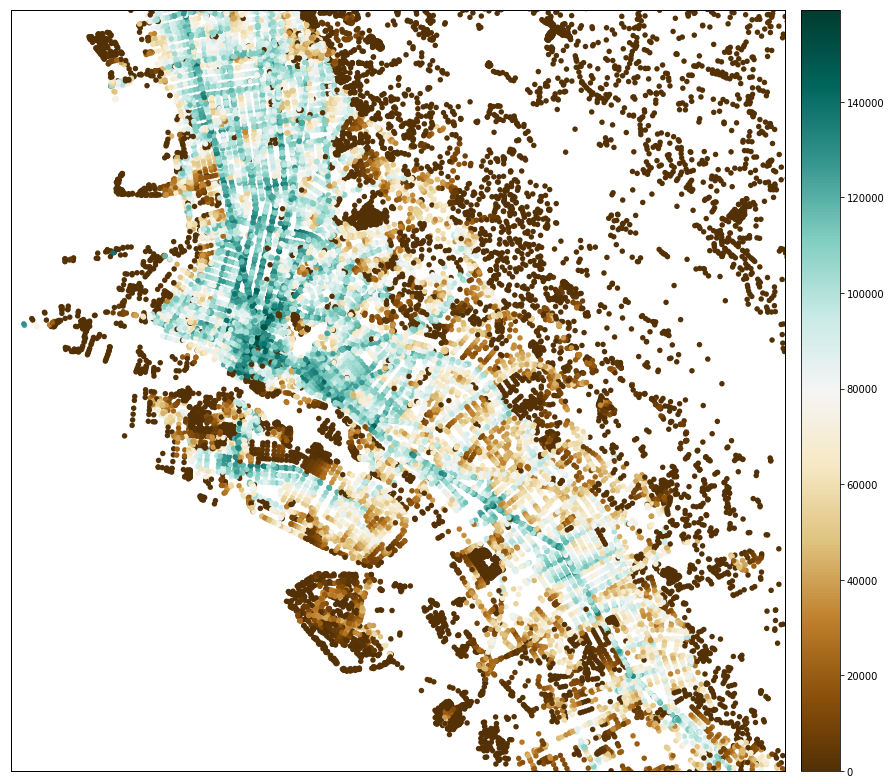

In [16]:
bbox = (37.6991981,-122.3426649,37.8847249,-122.1149234) #oakland
transit_net.plot(transit_jobs_20, 
         bbox=bbox,
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'3310','resolution':'h','area_thresh':100000000000000000},
         plot_kwargs={'cmap':'BrBG','s':30,'edgecolor':'none'})

You can combine census data with accessibility metrics in order to investigate patterns of low or high access neighborhoods and socioeconomics.

In [17]:
households.head()

,household_id,serialno,persons,cars,income,race_of_head,age_of_head,workers,children,tenure,recent_mover
block_id,,,,,,,,,,,
60816100001000,2,2.013000e+12,1.0,2.0,100000.0,1.0,43.0,1.0,0.0,1,0
60014251041009,97,2.013001e+12,1.0,1.0,65000.0,1.0,64.0,1.0,0.0,1,0
60014515033001,126,2.009000e+12,1.0,1.0,19200.0,1.0,64.0,0.0,0.0,1,0
60014419262000,142,2.013001e+12,1.0,1.0,14000.0,9.0,60.0,1.0,0.0,1,1
60014305002004,257,2.009001e+12,1.0,1.0,6000.0,1.0,93.0,0.0,0.0,1,0


In this case lets see what the relationship is between average household income and transit accessibility (using a 20 min travel time)

In [57]:
results_transit['av_inc'] = households.groupby(households.index).income.mean()
results_transit.head()

,transit_jobs_20,av_inc
block_id,,
60133452031015,0.00000,NaN
60014511013346,0.00000,127666.666667
60014507013074,0.00000,NaN
60133451111000,1053.28865,143714.697368
60014371011019,725.00000,200000.000000


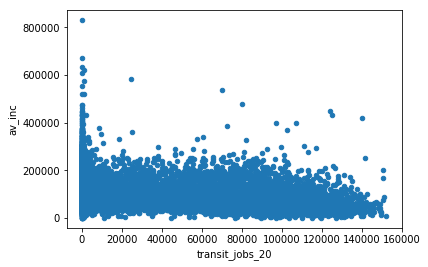

In [58]:
results_transit.plot.scatter(x='transit_jobs_20',y='av_inc')

# Compare accessibility using different networks: walking vs transit

# Pedestrian network

Download the pedestrian network from OSM: This includes all pedestrian accessible pathways including paths and stairways and omits auto only roads such as limited access highways

In [59]:
'''
%%time
h5file = 'osm_walk_2way_subset.h5'
network = pdna.loaders.osm.network_from_bbox(lat_min=37.454539, 
                                                lng_min=-122.342665, 
                                                lat_max=37.905668, 
                                                lng_max=-121.469214, 
                                                network_type='walk', 
                                                two_way=True)
lcn = network.low_connectivity_nodes(10000, 10, imp_name='distance')
network.save_hdf5(data_path+h5file, rm_nodes=lcn)
print('OSM data save completed:', data_path, h5file)
'''

"\n%%time\nh5file = 'osm_walk_2way_subset.h5'\nnetwork = pdna.loaders.osm.network_from_bbox(lat_min=37.454539, \n                                                lng_min=-122.342665, \n                                                lat_max=37.905668, \n                                                lng_max=-121.469214, \n                                                network_type='walk', \n                                                two_way=True)\nlcn = network.low_connectivity_nodes(10000, 10, imp_name='distance')\nnetwork.save_hdf5(data_path+h5file, rm_nodes=lcn)\nprint('OSM data save completed:', data_path, h5file)\n"

Load the pedestrian network, convert edge weight to walking travel time, and calculate the total number of jobs accessible with a 20 min walk. Then combine these results with those of the transit network accessibility metric and compare.

In [60]:
%%time
blocks = pd.read_csv(data_path+'blocks_subset.csv', index_col='block_id')
jobs = pd.read_csv(data_path+'jobs_subset.csv', index_col='job_id')

h5file = 'osm_walk_2way_subset.h5'
osm_walk_nodes = pd.HDFStore(data_path+h5file).nodes
osm_walk_edges = pd.HDFStore(data_path+h5file).edges
print('Loaded',str(len(osm_walk_nodes)),'nodes',str(len(osm_walk_edges)),'edges')

SPEED_MPH = 3
osm_walk_edges['travel_time_min'] = (osm_walk_edges['distance']/1609.34) / SPEED_MPH * 60
print('Converted edge weight')

walk_net = pdna.Network(osm_walk_nodes["x"], 
                   osm_walk_nodes["y"], 
                   osm_walk_edges["from"], 
                   osm_walk_edges["to"],
                   osm_walk_edges[["travel_time_min"]],twoway=True)
print('Network initialized')

blocks['node_id'] = walk_net.get_node_ids(blocks['x'], blocks['y'])
blocks['jobs'] = jobs.groupby(jobs.block_id).size()
walk_net.set(blocks.node_id, variable = blocks.jobs, name='jobs')
walk_jobs_20 = walk_net.aggregate(20, 
                              type='sum', 
                              decay='linear', 
                              name = 'jobs')
print('Aggregation completed')

results_walk = pd.DataFrame({'walk_jobs_20':misc.reindex(walk_jobs_20, blocks.node_id)})
results_combined = results_transit.join(results_walk, how='left', sort=False)
results_combined = results_combined.join(blocks[['x','y']], how='left', sort=False)
results_combined['access_diff'] = results_combined['walk_jobs_20']-results_combined['transit_jobs_20']
results_combined.tail()

Loaded 106165 nodes 153698 edges
Converted edge weight
Network initialized
Removed 18496 rows because they contain missing values
Aggregation completed
CPU times: user 14.4 s, sys: 166 ms, total: 14.5 s
Wall time: 14.5 s


## View the difference between the two results on a map

Blue = Transit network provides more access to jobs than pedestrian alone

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a34b3f828>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a33333470>)

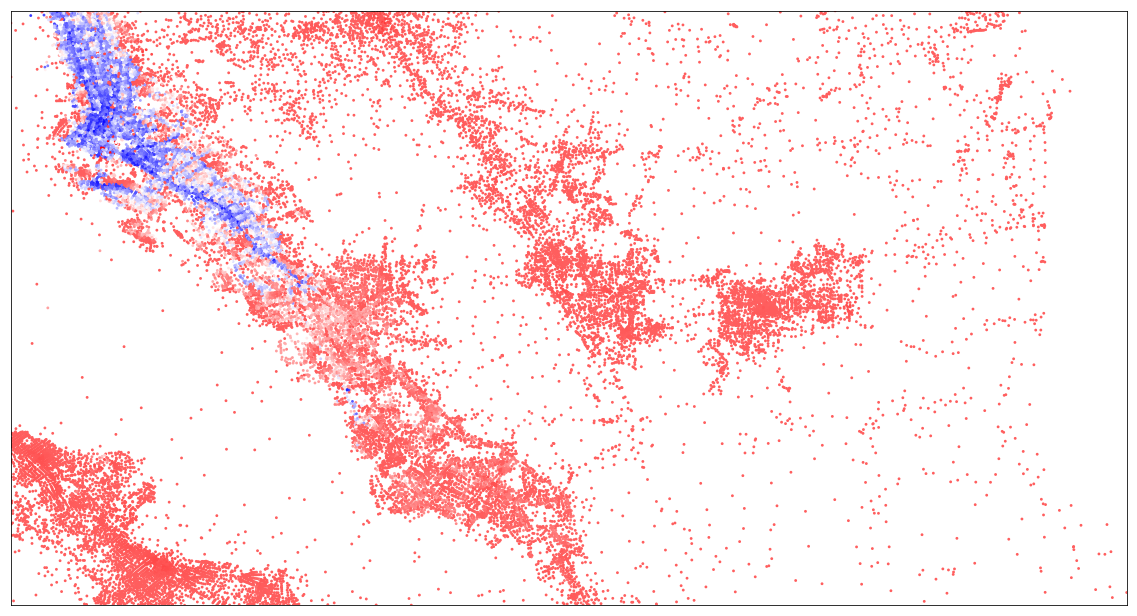

In [61]:
fig, ax = plt.subplots(figsize=[20,14])

bbox = (
    results_combined.y.min(),
    results_combined.x.min(),
    results_combined.y.max(),
    results_combined.x.max())

bmap = Basemap(bbox[1], bbox[0], bbox[3], bbox[2], ax=ax)
x, y = bmap(results_combined.x.values, results_combined.y.values)
plot = bmap.scatter(x, y, c=results_combined.access_diff.values, cmap='bwr',s=8,edgecolor='none')
bmap, fig, ax

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a27efac50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a34b7ceb8>)

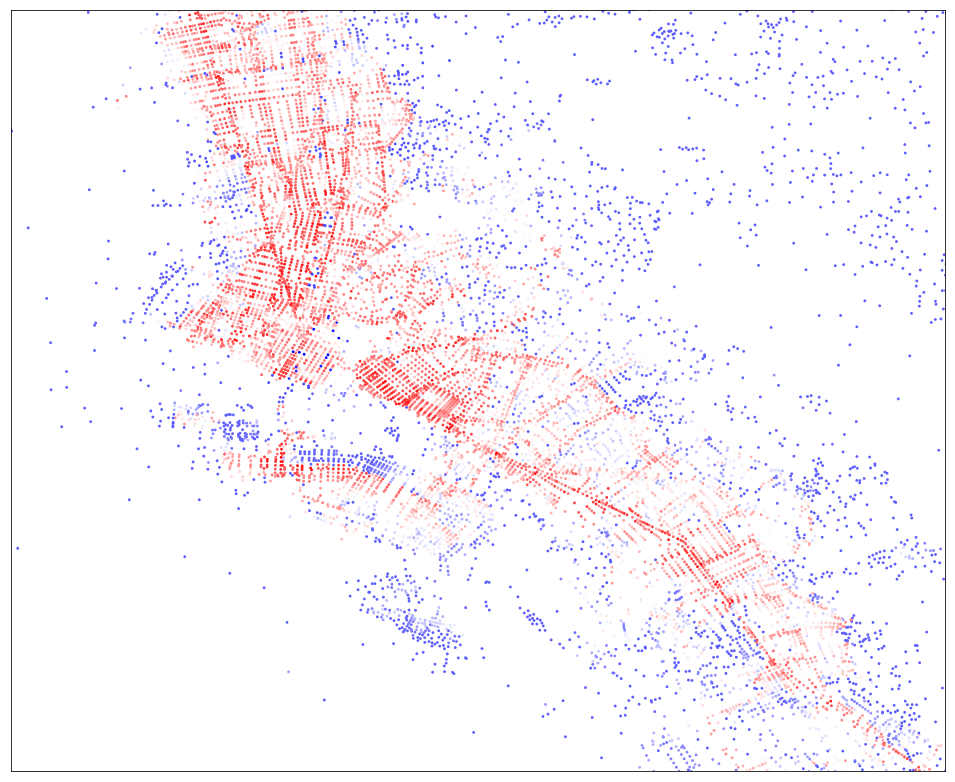

In [62]:
fig, ax = plt.subplots(figsize=[20,14])
bbox = (37.6991981,-122.3426649,37.8847249,-122.1149234) # Oakland

bmap = Basemap(bbox[1], bbox[0], bbox[3], bbox[2], ax=ax)
x, y = bmap(results_combined.x.values, results_combined.y.values)
plot = bmap.scatter(x, y, c=results_combined.access_diff.values, cmap='bwr_r',s=8,edgecolor='none')
bmap, fig, ax